### Train a binary classifier to distinguish between spurious_correlated VS genuine_correlated words
- [Manually label top_features](#labeled_wds) (coef > thresh, min_df > 10 in ites)
> good/genuine: 1, bad/spurious: -1

- [Feature representation for each word](#ite_features)
> 18 ite features <br>
> 40 pca features <br>
> 1 coef feature <br>

- Classifier:
> LogisticRegression(class_weight='balanced')

- [Prediction and evaluation](#word_classification)
> Self_evaluation on source domain (not oob) <br>
> 5 fold cross validation on source domain (oob) <br>
> Predict and evaluate on target domain (oob) <br>

In [2]:
from adjustText import adjust_text
import copy, io, time
from io import BytesIO
from itertools import combinations, cycle, product
from collections import Counter, defaultdict
from IPython.display import display
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', -1)

import pickle, tarfile, random
from scipy.sparse import hstack, lil_matrix

from tqdm.notebook import tqdm

import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, scale, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")

In [3]:
from data_structure import Dataset, SentenceEdit
from spurious_words import get_spurious_words

#### Get human labeled spurious words <a id='labeled_wds'></a>

In [3]:
def load_matched_data(matchby='placebo'):
    """
    Load matched sentences from pre-calculated results;
    Sentences matched using different strategies:
        - treat / control / placebo
    
    """   
    path = '/data/zwang/2020_S/EMNLP/'
    
    if(matchby == 'treat'):
        [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw] = pickle.load(open(path+'V_1_treat/datasets_treat_match.pickle', 'rb'))
        ds_kindle = pickle.load(open('/data/zwang/2020_S/EMNLP/V_6_shortSents/kindle_treat_match.pickle', 'rb'))
        ds_toxic = pickle.load(open('/data/zwang/2020_S/EMNLP/V_6_shortSents/toxic_treat_match.pickle', 'rb'))

    elif(matchby == 'control'):
        [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw] = pickle.load(open(path+'V_2_control/datasets_control_match.pickle', 'rb'))
    elif(matchby == 'placebo'):
        [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw] = pickle.load(open(path+'V_3_placebo/datasets_placebo_match.pickle','rb'))
    
    """
    Manually labeled spurious terms
    """
    spurious_words_map = get_spurious_words()
    for ds_data in [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw]:
        ds_data.BAD_POS = spurious_words_map[ds_data.moniker+'_bad_pos']
        ds_data.BAD_NEG = spurious_words_map[ds_data.moniker+'_bad_neg']
        ds_data.ALL_BAD = ds_data.BAD_POS + ds_data.BAD_NEG
        ds_data.DUMMY_TERM = 'xxxxx'

    
    return ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw

In [6]:
# ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw = load_matched_data(matchby='treat')

#### Represent each word with features calculated from ite match <a id='ite_features'> </a>

In [4]:
def get_most_similar_match_with_label(term_df, label):
    """
    For a given label, check if there's a matched control sample have the same label
    In the word's ITE dataframe: 
        For each sentence, find a matched sample with the given label
        Sort in similarity descending order
    """
    has_match = False
    for s_obj in term_df.control_obj:
        if s_obj.label == label:
            has_match = True
    
    if has_match:
        return sorted([(sim,s_obj) for sim,s_obj in zip(term_df.similarity_scaled, term_df.control_obj) if s_obj.label==label], key=lambda i: i[0])[::-1][0][0]
    else:
        return 0


In [5]:
def scale_values(values_to_scale):
    """
    values to scale: 2d array, feature matrix, if it is 1-d, transfer to a 2d matrix with one column
    Separately scale each feature column to (0,1)
    """
    my_scaler = MinMaxScaler()
    
    if(len(values_to_scale.shape)==1):
        return my_scaler.fit_transform(values_to_scale.reshape(len(values_to_scale),1)).transpose()[0]
    elif(len(values_to_scale.shape)==2):
        return my_scaler.fit_transform(values_to_scale)

In [6]:
def compute_ite_features(ds_ite, groupby='term', min_df=10):
    """
    ds_ite:
        - dataframe of ['term','sentence_id','treat_obj','control_obj','similarity','difference', 'ite']
    Group ite dataframe by term;
    Each word is a sample, labeled as good/bad;
    Get feature representations for each word, features generated from term_ites (term_ites are matched sentences regarding that term).
    """
    
    ds_ite['similarity_scaled'] = scale_values(ds_ite.similarity.values)
    
    features_fromItes = []
    
    for term, term_df in ds_ite.fillna(0).groupby(groupby):
        # term and correpsonding term_df
        if len(term_df) >= min_df:
            features_fromItes.append({
                'term': '%s%s' % (term, '' if groupby=='term' else '-dummy'),

                'ite_abs_avg': abs(term_df.ite.mean()), # average over word ites (ite = treat label - control label)
                'ite_abs_top_5': abs(np.mean(sorted(np.abs(term_df.ite))[::-1][:5])), # top-5 highest abs(ite)

                'similarity_scaled_avg': term_df.similarity_scaled.mean(), # context similarity
                'similarity_scaled_top_5': np.mean(sorted(term_df.similarity_scaled)[::-1][:5]),
                'similarity_scaled_std': term_df.similarity_scaled.std(),
                'similarity_scaled_max': term_df.similarity_scaled.max(),
#                'closest_same_label_similarity_scaled': get_most_similar_match_with_label(term_df, 1 if ('-dummy' not in term_df.term.values[0] or term_df.coef.values[0] > 0) else -1),
#                'closest_diff_label_similarity_scaled': get_most_similar_match_with_label(term_df, -1 if ('-dummy' not in term_df.term.values[0] or term_df.coef.values[0] > 0) else 1),
                 'closest_pos_similarity_scaled': get_most_similar_match_with_label(term_df, 1),
                 'closest_neg_similarity_scaled': get_most_similar_match_with_label(term_df, -1),
#                 'similarity_scaled_min': term_df.similarity_scaled.min(),
#                 'similarity_scaled_max-min': term_df.similarity_scaled.max()-term_df.similarity_scaled.min(),                
                
                'ite_abs_top_5_by_sim': abs(np.mean([i[1] for i in sorted(zip(term_df.similarity_scaled, term_df.ite))[::-1][:5]])), # top-5 most similar 
                'ite_weighted_scaled': abs(np.average(term_df.ite.values, weights=term_df.similarity_scaled.values)), #ite weight by similarity

                'ite_x_similarity_scaled' : math.sqrt(abs(term_df.ite.mean()) * term_df.similarity_scaled.mean()),# avg_ite*avg_sim
                'ite_x_similarity_scaled_top_5' : math.sqrt(abs(term_df.ite.mean()) * np.mean(sorted(term_df.similarity_scaled)[::-1][:5])),

                'diff_mean_vec': np.mean(term_df.difference, axis=0), # mean of the terms' all diff vecs
                'diff_mean_abs': abs(np.mean(term_df.difference, axis=0).mean()),
                'diff_mean': np.mean(term_df.difference, axis=0).mean(), # mean over diff vecs, then mean over all dimensions
                
                'top_diff_mean': np.mean(sorted(np.mean(term_df.difference, axis=0))[::-1][:3]), # top-3 dims
                'diff_max_mean_abs': np.mean(np.max([np.abs(i) for i in term_df.difference.values], axis=0)), # abs max along each dim
                'diff_max_mean': np.mean(np.max([i for i in term_df.difference.values], axis=0)), # max along each dim
                'diff_min_mean': np.mean(np.min([i for i in term_df.difference.values], axis=0))        
            })
        
        
    return pd.DataFrame(features_fromItes)

In [7]:
def fit_pca(train_features_df, test_features_df, dim=40):
    """
    Separately scale train vec and test vec;
    Fit pca on :
        Training data;
        Concatenation of train and test;
    """
    
    pca = PCA(n_components=dim, random_state=42)
    
    scaled_train_diff_mean_vec = scale_values(np.array([i for i in train_features_df.diff_mean_vec.values]))
    
#     return pca.fit(scaled_train_diff_mean_vec) # pca only fit on training data
    scaled_test_diff_mean_vec = scale_values(np.array([i for i in test_features_df.diff_mean_vec.values]))
    
    pca.fit(np.vstack((scaled_train_diff_mean_vec,scaled_test_diff_mean_vec)))
    
    return pca

In [8]:
def set_term_coef(ites_df, X, y, feats):
    """
    Get coef for each term (terms that have ite dataframe);
    Coef as one of words' features;
    """
    clf = LogisticRegression(class_weight='auto', C=1, solver='lbfgs', max_iter=1000)
    clf.fit(X, y)
    
    term2coef = {feats[i]:c for i,c in enumerate(clf.coef_[0])}
    ites_df['coef'] = [float("%.3f" % term2coef[t]) if t in term2coef else 0 for t in ites_df.term]    
    
#     return ites_df

In [9]:
def get_color(term, ds):
    """
    Different text color indicate different terms (good, bad, dummy)
    """
    try:
        if term == ds.DUMMY_TERM or 'dummy' in term:
            return 'blue'
        elif term in ds.BAD_POS:
            return 'green'
        elif term in ds.BAD_NEG:
            return 'red'
        else:
            return 'black'
    except:
        return 'yellow'
    
def plot_wdClf_prediction(features_df, ds, prob='in_domain'):
    """
    x-axis: coef;
    y-axis: p(y=good|word) from word classifier;
    if prob =='in-domain':
        y_axis = 'cv_prob'
    elif prob == 'out-domain':
        y_axis = 'domain_transfer_prob'
    """
    if(ds.moniker in ['toxic','toxic_tw']): # only consider pos/toxic class in toxic dataset
        lb_list = ['pos']
    else:
        lb_list = ['pos','neg']
    
    for label in lb_list:
        plt.figure(figsize=(12,8))
        show_feat_df = features_df.dropna()
        if(label=='pos'):
            show_feat_df = show_feat_df[show_feat_df.coef > 0]
        else:
            show_feat_df = show_feat_df[show_feat_df.coef < 0]
#         itesi = itesi[itesi.coef > 0] if label=='pos' else itesi[itesi.coef < 0]
        xcol = 'coef'
        
        if prob =='in_domain':
            ycol = 'cv_prob'
        elif prob == 'out_domain':
            ycol = 'domain_transfer_prob'

        x_vals = show_feat_df[xcol]
        y_vals = show_feat_df[ycol]
        plt.scatter(x_vals, y_vals, alpha=.5)    
        
        text = [plt.text(xv,yv,term, ha='center', color=get_color(term, ds), alpha=.8, va='center')
            for xv,yv,term in zip(x_vals, y_vals, show_feat_df.term)]
        
        plt.axhline(.5)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.title(ds.moniker+" | text color: (Blue: dummy; Green: bad_pos, red: bad_neg, black: others;)")
        adjust_text(text, lim=10) # slow
        plt.show()


#### Run word classifier <a id='word_classification'> </a>

In [10]:
def do_cv(X, y, n=5):
    """
    5-fold cross_validation for word classifier;
    class_weight = 'auto' VS 'balanced' VS 'None'
    """
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    preds = np.zeros(len(y), y.dtype)
    probs = np.zeros(len(y), np.float)    
    
    for train, test in kf.split(X):
        clf.fit(X[train], y[train])
        preds[test] = clf.predict(X[test])
        probs[test] = clf.predict_proba(X[test])[:,1]        
    
    return preds, probs

In [11]:
def word_classifier(ds_src, ds_tar, show_src=True, use_coef=True, use_pca=True):
    """
    ds_src: source domain;
    ds_tar: target domain;
    ds_data.ites: :
        - dataframe of ['term','sentence_id','treat_obj','control_obj','similarity','difference', 'ite']
    
    Represent each word with following features: 
    - 18 ite features;
    - 1 coef feature (optional);
    - 40 pca features (optional, using pca features complex the problem);
                    
    Binary word classifier to distinguish between GOOD (1) and BAD (-1) words:
    - Self evaluation;
    - Same domain cross validation (ds_src == ds_tar);
    - Domain transfer: fit classifier on source domain, and predict on target domain (ds_src != ds_tar);
    
    """
    
    # get 19 ite features + 1 coef feature
    src_features_df = compute_ite_features(ds_src.ites)
    tar_features_df = compute_ite_features(ds_tar.ites)
    
    set_term_coef(src_features_df, ds_src.X, ds_src.y, ds_src.feats)
    set_term_coef(tar_features_df, ds_tar.X, ds_tar.y, ds_tar.feats)
         
#     print(src_features_df.shape, tar_features_df.shape)
    
    # For toxic dataset, only check BAD_POS and GOOD_POS
    if(ds_src.moniker in ['toxic','toxic_tw']): 
        src_features_df = src_features_df[src_features_df['coef']>0]
        tar_features_df = tar_features_df[tar_features_df['coef']>0]
        print("Source: (%s, %d), target: (%s, %d), only use pos(toxic) words" % (ds_src.moniker,src_features_df.shape[0],ds_tar.moniker,tar_features_df.shape[0]))
        
    
    # 40 PCA features from mean vectors of embedding differences
    if(use_pca):
        dim=40
        fitted_pca = fit_pca(src_features_df, tar_features_df, dim)

        src_pca = fitted_pca.transform(scale_values(np.array([i for i in src_features_df.diff_mean_vec.values])))
        src_pca_df = pd.DataFrame(src_pca, columns=['pca_%d' % i for i in range(dim)])
        src_features_df = pd.concat([src_features_df.reset_index(drop=True, inplace=False), src_pca_df], axis=1)
        feats_colm = np.array([i for i in src_features_df.columns if i not in ['diff_mean_vec', 'term', 'good_term', 'label']])
        X_src = scale(src_features_df[feats_colm])

        tar_pca = fitted_pca.transform(scale_values(np.array([i for i in tar_features_df.diff_mean_vec.values])))
        tar_pca_df = pd.DataFrame(tar_pca, columns=['pca_%d' % i for i in range(dim)])
        tar_features_df = pd.concat([tar_features_df.reset_index(drop=True, inplace=False), tar_pca_df], axis=1)
        X_tar = scale(tar_features_df[feats_colm])
    else:
        feats_colm = np.array([i for i in src_features_df.columns if i not in ['diff_mean_vec', 'term', 'good_term', 'label']])
        X_src = scale(src_features_df[feats_colm])
        X_tar = scale(tar_features_df[feats_colm])
#         print(X_src.shape)
    
    # Assign label: bad_term assign -1, others assign 1
    y_src = np.array([-1 if term in ds_src.ALL_BAD else 1 for term in src_features_df.term] )
    src_features_df['label'] = y_src
    print(ds_src.moniker+" (source), bad VS good terms: ",sorted(Counter(y_src).items()))
    
    # fit word classifier
    wd_clf = LogisticRegression(C=1, class_weight='balanced', solver='lbfgs', max_iter=1000)
    wd_clf.fit(X_src, y_src)

    # show important features of word classifier
    print('\nFeature importance: ',sorted([item for item in zip([float("%.2f" % c) for c in wd_clf.coef_[0]],feats_colm)]))
    
    # self evaluation (train and predict on same data)
    print("\n%s --> %s, self-evaluation:\n" % (ds_src.moniker, ds_src.moniker))
    print(classification_report(y_src, wd_clf.predict(X_src)))

    # cross validation on source domain
    y_src_pred_lb, y_src_pred_prob = do_cv(X_src, y_src, n=10)
    print("\n%s --> %s, 5-fold cross validation, auc: %.3f:" % (ds_src.moniker, ds_src.moniker, 
                                                                roc_auc_score(y_src, y_src_pred_prob)))
    src_report = classification_report(y_src, y_src_pred_lb, output_dict=True)
    print(classification_report(y_src, y_src_pred_lb))
    
    src_features_df['cv_prob'] = y_src_pred_prob 
    ds_src.term_df = src_features_df # 59 features + term + label
    
    if(show_src):
        plot_wdClf_prediction(src_features_df, ds_src, prob='in_domain') # oob probas
        
    # domain transfer: train on words from source domain, predict on words from target domain
    y_tar = np.array([-1 if term in ds_tar.ALL_BAD else 1 for term in tar_features_df.term] )
    tar_features_df['label'] = y_tar
    print(ds_tar.moniker+" (target), bad VS good terms: ",sorted(Counter(y_tar).items()))
    
    y_tar_pred_lb = wd_clf.predict(X_tar)
    y_tar_pred_prob = wd_clf.predict_proba(X_tar)[:,1]
    print("\n%s --> %s, domain transfer, auc: %.3f: \n" % (ds_src.moniker, ds_tar.moniker, 
                                                           roc_auc_score(y_tar, y_tar_pred_prob)))
    tar_report = classification_report(y_tar, y_tar_pred_lb, output_dict=True)
    print(classification_report(y_tar, y_tar_pred_lb))
    
    y_tar_cv_pred_lb, y_tar_cv_pred_prob = do_cv(X_tar, y_tar, n=10)
    tar_features_df['cv_prob'] = y_tar_cv_pred_prob
    tar_features_df['domain_transfer_prob'] = y_tar_pred_prob
    ds_tar.term_df = tar_features_df
    plot_wdClf_prediction(tar_features_df, ds_tar, prob='out_domain')
    
    return ds_src, ds_tar, src_report, tar_report

In [12]:
def run_word_classifier(matchby):
    """
    For document classification task
    """
#     path = '/data/zwang/2020_S/Toxic/Concat_last4_emb/'
#     file_map = {m:i for i,m in enumerate(['','treat','control','placebo'])}
#     folder = path+'V_' + str(file_map[matchby]) + '_' + matchby # V_1_treat, V_2_control, V_3_placebo
    
    folder = '/data/zwang/2020_S/EMNLP/V_7_rerun/'
    
    ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw = load_matched_data(matchby = matchby)
    
    ds_prob = [] # ds_data could update in later change
    In_domain_result = {}
    Out_domain_result = {}
    
    for ds_src, ds_tar in zip([ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw],[ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic]):
        print(ds_src.moniker,'-->', ds_tar.moniker)
        
        ds_src, ds_tar, src_report, tar_report = word_classifier(ds_src, ds_tar, show_src=False, use_coef=True, use_pca=False)
        ds_prob.append(copy.deepcopy(ds_tar))
        
        In_domain_result[ds_src.moniker] = src_report
        Out_domain_result[ds_tar.moniker] = tar_report
      
#     pickle.dump(ds_prob,open(folder+'/datasets_with_term_prob.pickle','wb'))

#     pickle.dump(src2src_prob,open(folder+'/datasets_src2src_5cv_prob.pickle','wb'))
    
    return In_domain_result, Out_domain_result

#### Matched sentences using treat match

imdb --> kindle
imdb (source), bad VS good terms:  [(-1, 90), (1, 174)]

Feature importance:  [(-0.6, 'diff_min_mean'), (-0.55, 'diff_max_mean_abs'), (-0.5, 'closest_neg_similarity_scaled'), (-0.46, 'closest_pos_similarity_scaled'), (-0.4, 'ite_x_similarity_scaled_top_5'), (-0.38, 'ite_x_similarity_scaled'), (-0.28, 'ite_abs_top_5'), (-0.25, 'top_diff_mean'), (-0.21, 'similarity_scaled_top_5'), (-0.09, 'diff_mean'), (-0.09, 'ite_abs_top_5_by_sim'), (0.09, 'diff_mean_abs'), (0.14, 'diff_max_mean'), (0.23, 'ite_weighted_scaled'), (0.32, 'coef'), (0.8, 'ite_abs_avg'), (0.8, 'similarity_scaled_std'), (0.96, 'similarity_scaled_max'), (1.31, 'similarity_scaled_avg')]

imdb --> imdb, self-evaluation:

              precision    recall  f1-score   support

          -1       0.60      0.74      0.67        90
           1       0.85      0.75      0.80       174

    accuracy                           0.75       264
   macro avg       0.73      0.75      0.73       264
weighted avg       0.77 

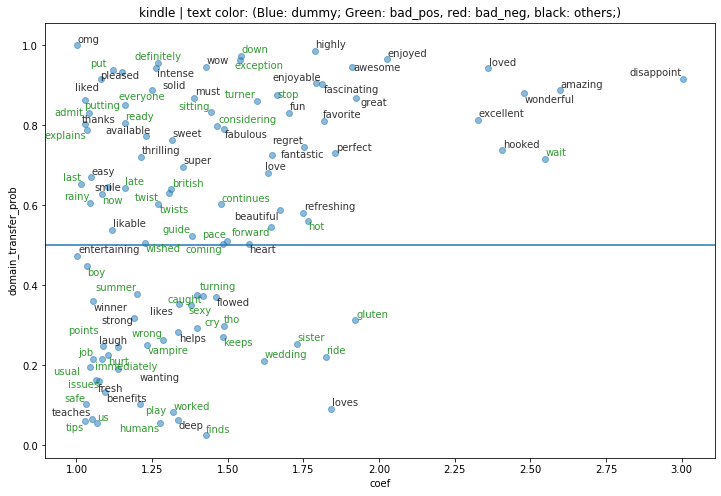

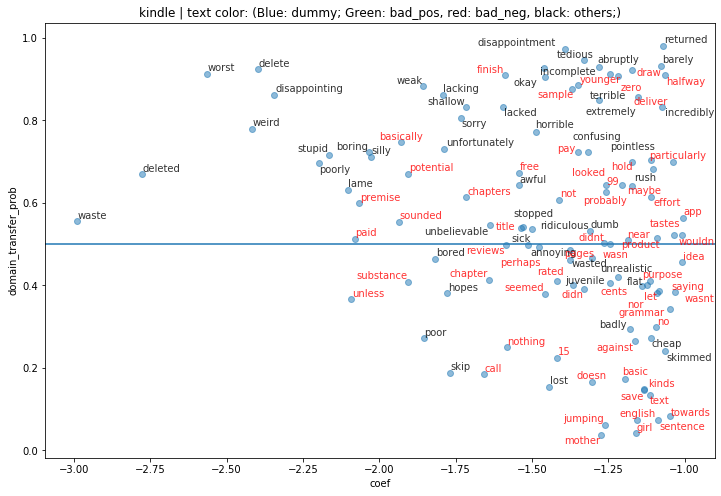

kindle --> imdb
kindle (source), bad VS good terms:  [(-1, 119), (1, 100)]

Feature importance:  [(-0.55, 'ite_abs_top_5'), (-0.53, 'ite_weighted_scaled'), (-0.4, 'diff_max_mean_abs'), (-0.36, 'closest_neg_similarity_scaled'), (-0.22, 'ite_abs_avg'), (-0.08, 'diff_min_mean'), (0.0, 'diff_mean'), (-0.0, 'diff_mean_abs'), (0.07, 'ite_abs_top_5_by_sim'), (0.1, 'coef'), (0.14, 'similarity_scaled_top_5'), (0.18, 'similarity_scaled_max'), (0.18, 'similarity_scaled_std'), (0.22, 'top_diff_mean'), (0.23, 'closest_pos_similarity_scaled'), (0.25, 'diff_max_mean'), (0.45, 'similarity_scaled_avg'), (0.53, 'ite_x_similarity_scaled'), (0.73, 'ite_x_similarity_scaled_top_5')]

kindle --> kindle, self-evaluation:

              precision    recall  f1-score   support

          -1       0.71      0.66      0.69       119
           1       0.63      0.68      0.65       100

    accuracy                           0.67       219
   macro avg       0.67      0.67      0.67       219
weighted avg       0

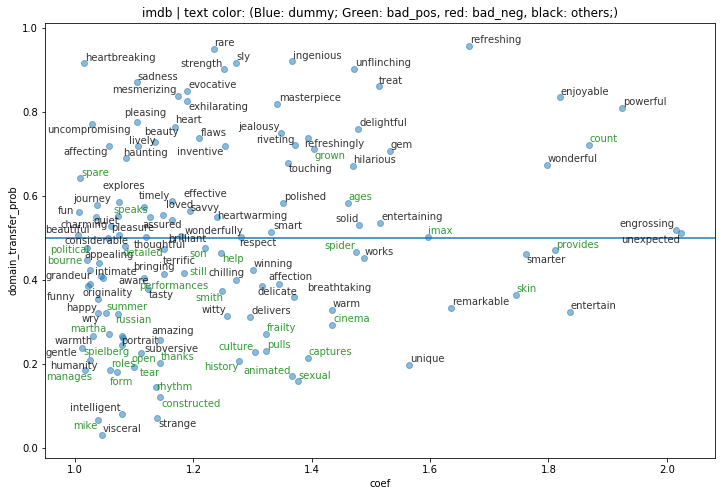

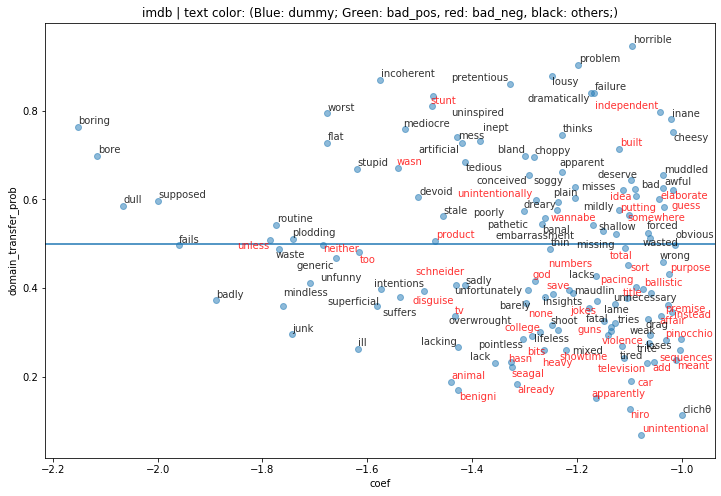

toxic --> toxic_tw
Source: (toxic, 113), target: (toxic_tw, 117), only use pos(toxic) words
toxic (source), bad VS good terms:  [(-1, 40), (1, 73)]

Feature importance:  [(-0.61, 'ite_abs_top_5'), (-0.3, 'similarity_scaled_max'), (-0.14, 'ite_x_similarity_scaled'), (-0.13, 'ite_abs_avg'), (-0.13, 'ite_abs_top_5_by_sim'), (-0.1, 'diff_mean_abs'), (-0.07, 'diff_min_mean'), (-0.04, 'ite_x_similarity_scaled_top_5'), (0.03, 'diff_max_mean'), (0.04, 'closest_pos_similarity_scaled'), (0.06, 'closest_neg_similarity_scaled'), (0.1, 'diff_mean'), (0.14, 'diff_max_mean_abs'), (0.32, 'similarity_scaled_avg'), (0.37, 'top_diff_mean'), (0.43, 'ite_weighted_scaled'), (0.55, 'similarity_scaled_std'), (1.07, 'similarity_scaled_top_5'), (1.47, 'coef')]

toxic --> toxic, self-evaluation:

              precision    recall  f1-score   support

          -1       0.72      0.90      0.80        40
           1       0.94      0.81      0.87        73

    accuracy                           0.84       113
 

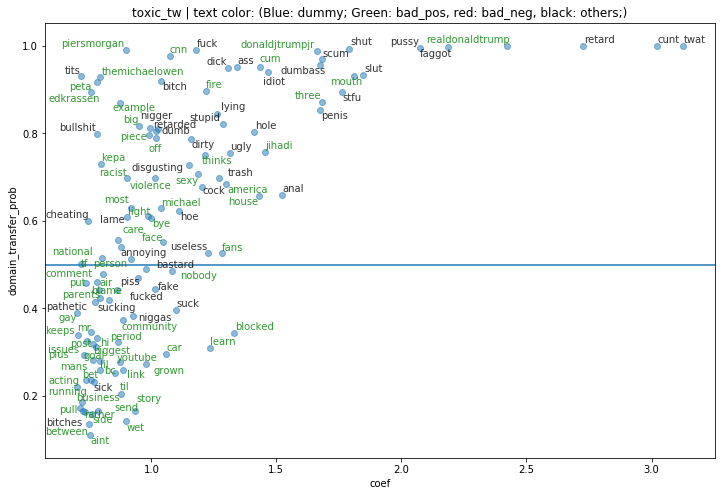

toxic_tw --> toxic
Source: (toxic_tw, 117), target: (toxic, 113), only use pos(toxic) words
toxic_tw (source), bad VS good terms:  [(-1, 72), (1, 45)]

Feature importance:  [(-0.86, 'ite_weighted_scaled'), (-0.37, 'diff_min_mean'), (-0.3, 'ite_abs_top_5'), (-0.28, 'similarity_scaled_avg'), (-0.21, 'similarity_scaled_max'), (-0.19, 'similarity_scaled_top_5'), (0.07, 'closest_pos_similarity_scaled'), (0.07, 'diff_max_mean'), (0.1, 'top_diff_mean'), (0.16, 'ite_x_similarity_scaled_top_5'), (0.2, 'ite_x_similarity_scaled'), (0.23, 'diff_mean_abs'), (0.3, 'diff_max_mean_abs'), (0.31, 'ite_abs_avg'), (0.32, 'similarity_scaled_std'), (0.33, 'closest_neg_similarity_scaled'), (0.37, 'diff_mean'), (0.42, 'ite_abs_top_5_by_sim'), (0.79, 'coef')]

toxic_tw --> toxic_tw, self-evaluation:

              precision    recall  f1-score   support

          -1       0.81      0.79      0.80        72
           1       0.68      0.71      0.70        45

    accuracy                           0.76      

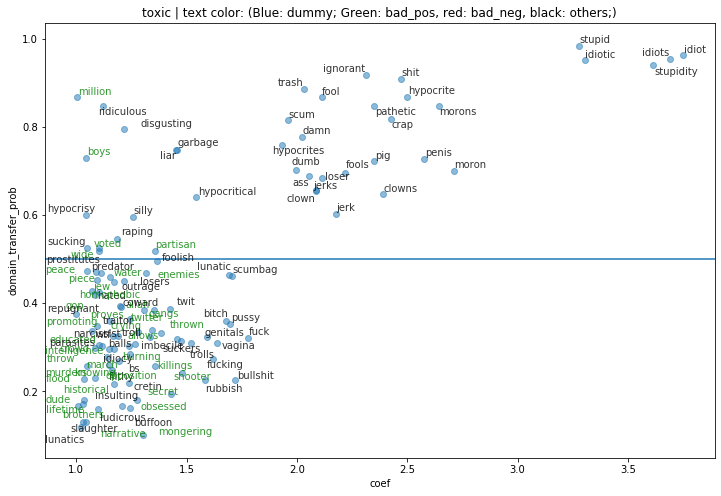

In [13]:
treat_in_domain_result, treat_out_domain_result = run_word_classifier(matchby='treat')

#### Matched sentences using placebo match

In [17]:
# treat_in_domain_result, treat_out_domain_result = run_word_classifier(matchby='placebo')

#### Matched sentences using control match

In [18]:
# treat_in_domain_result, treat_out_domain_result = run_word_classifier(matchby='control')

#### Print both good words and bad words

In [4]:
ds_data = pickle.load(open('/data/zwang/2020_S/EMNLP/V_7_rerun/datasets_with_term_prob.pickle','rb'))
type(ds_data)

list

In [17]:
imdb_good_pos = ds_data[1].term_df[(ds_data[1].term_df.label==1) & (ds_data[1].term_df.coef>0)]
imdb_good_neg = ds_data[1].term_df[(ds_data[1].term_df.label==1) & (ds_data[1].term_df.coef<0)]
imdb_bad_pos = ds_data[1].term_df[(ds_data[1].term_df.label==-1) & (ds_data[1].term_df.coef>0)]
imdb_bad_neg = ds_data[1].term_df[(ds_data[1].term_df.label==-1) & (ds_data[1].term_df.coef<0)]
imdb_good_pos.shape, imdb_good_neg.shape, imdb_bad_pos.shape, imdb_bad_neg.shape

((89, 24), (85, 24), (38, 24), (52, 24))

In [37]:
imdb_good_pos.sort_values(by=['coef'],ascending=False).head(20)

,term,ite_abs_avg,ite_abs_top_5,similarity_scaled_avg,similarity_scaled_top_5,similarity_scaled_std,similarity_scaled_max,closest_pos_similarity_scaled,closest_neg_similarity_scaled,ite_abs_top_5_by_sim,...,diff_mean_abs,diff_mean,top_diff_mean,diff_max_mean_abs,diff_max_mean,diff_min_mean,coef,label,cv_prob,domain_transfer_prob
237,unexpected,0.800000,2.0,0.563203,0.673703,0.093448,0.745566,0.745566,0.711703,0.8,...,0.002263,-0.002263,0.574328,0.449682,0.380301,-0.386594,2.025,1,0.735641,0.510979
61,engrossing,0.424242,2.0,0.588532,0.709383,0.076124,0.804833,0.804833,0.647729,0.0,...,0.001795,-0.001795,0.365265,0.460384,0.401349,-0.408149,2.016,1,0.867307,0.519382
161,powerful,0.784314,2.0,0.606522,0.782517,0.093539,0.847727,0.847727,0.766966,0.4,...,0.001468,-0.001468,0.462299,0.484430,0.427621,-0.430348,1.925,1,0.900037,0.810374
63,entertain,0.666667,1.6,0.570982,0.615021,0.047253,0.659593,0.631273,0.659593,0.8,...,0.001614,-0.001614,0.278429,0.387579,0.314670,-0.320537,1.836,1,0.378081,0.323675
62,enjoyable,0.426230,2.0,0.629840,0.874220,0.110068,1.000000,1.000000,0.999999,0.4,...,0.001310,-0.001310,0.416303,0.489578,0.434529,-0.436657,1.819,1,0.977711,0.834836
258,wonderful,0.647059,2.0,0.615557,0.746059,0.079050,0.760613,0.760613,0.757085,1.2,...,0.001306,-0.001306,0.445568,0.451231,0.390719,-0.394595,1.797,1,0.916552,0.674051
195,smarter,1.000000,2.0,0.569536,0.625915,0.074250,0.678243,0.678243,0.643967,0.8,...,0.001708,-0.001708,0.510566,0.387968,0.319780,-0.316717,1.762,1,0.595888,0.461744
172,refreshing,0.869565,2.0,0.687548,0.903217,0.141908,1.000000,0.824748,1.000000,1.6,...,0.001104,-0.001104,0.293182,0.394281,0.332445,-0.334738,1.666,1,0.999677,0.957958
174,remarkable,0.363636,2.0,0.579036,0.693059,0.078882,0.718364,0.715150,0.718364,0.8,...,0.001272,-0.001272,0.495738,0.459324,0.402131,-0.401396,1.635,1,0.420749,0.333966
244,unique,0.260870,2.0,0.567705,0.648392,0.071001,0.681845,0.681845,0.623000,0.0,...,0.001747,-0.001747,0.483107,0.433200,0.370671,-0.375258,1.565,1,0.373757,0.197834


In [ ]:
bad_pos = ['provides','imax','spider','cinema','sexual','tear','detailed','spielberg','russian','roles']
bad_neg = ['animal', 'tv', 'seagal', 'god', 'heavy', 'jokes','guns','violence','disguise','unintentionally']
good_pos = ['unexpected', 'engrossing','entertain','wonderful','smarter','unique','gem','treat','works','solid']
good_neg = ['boring','bore','dull','fails','routine','waste','mindless','unfunny','flat','generic']

#### Percentage of out-of-vocabulary words

In [4]:
from spurious_words import imdb_bad_pos, imdb_bad_neg, kindle_bad_pos, kindle_bad_neg, toxic_bad_pos, toxic_tw_bad_pos

In [15]:
len(set(imdb_bad_pos + imdb_bad_neg)), len(set(kindle_bad_pos + kindle_bad_neg)), len(set(imdb_bad_pos + imdb_bad_neg).intersection(set(kindle_bad_pos + kindle_bad_neg)))

(145, 154, 12)

In [10]:
12 / 152

0.07894736842105263

In [16]:
len(set(toxic_bad_pos)), len(set(toxic_tw_bad_pos)), len(set(toxic_bad_pos).intersection(set(toxic_tw_bad_pos)))

(72, 139, 3)

In [14]:
3 / 139

0.02158273381294964

In [13]:
len(toxic_tw_bad_pos)

139